Extracted 161 patterns.
Mapped patterns to sentences.
Encoded patterns into one-hot vectors.
Performing dimensionality reduction using LSA with params {'n_components': 2}
Dimensionality reduction using LSA completed.
Clustering sentences using KMeans with params {'n_clusters': 3}
Clustering using KMeans completed.

Similarity Scores between Generated Clusters and Reference Clusters:
Ref 0 matches Gen 0 with Jaccard similarity: 0.6000
Ref 1 matches Gen 1 with Jaccard similarity: 0.6667
Ref 2 matches Gen 2 with Jaccard similarity: 0.5000
Performing dimensionality reduction using LSA with params {'n_components': 2}
Dimensionality reduction using LSA completed.
Clustering sentences using Agglomerative with params {'n_clusters': 3}
Clustering using Agglomerative completed.

Similarity Scores between Generated Clusters and Reference Clusters:
Ref 0 matches Gen 0 with Jaccard similarity: 0.6000
Ref 1 matches Gen 1 with Jaccard similarity: 0.6667
Ref 2 matches Gen 2 with Jaccard similarity: 0.

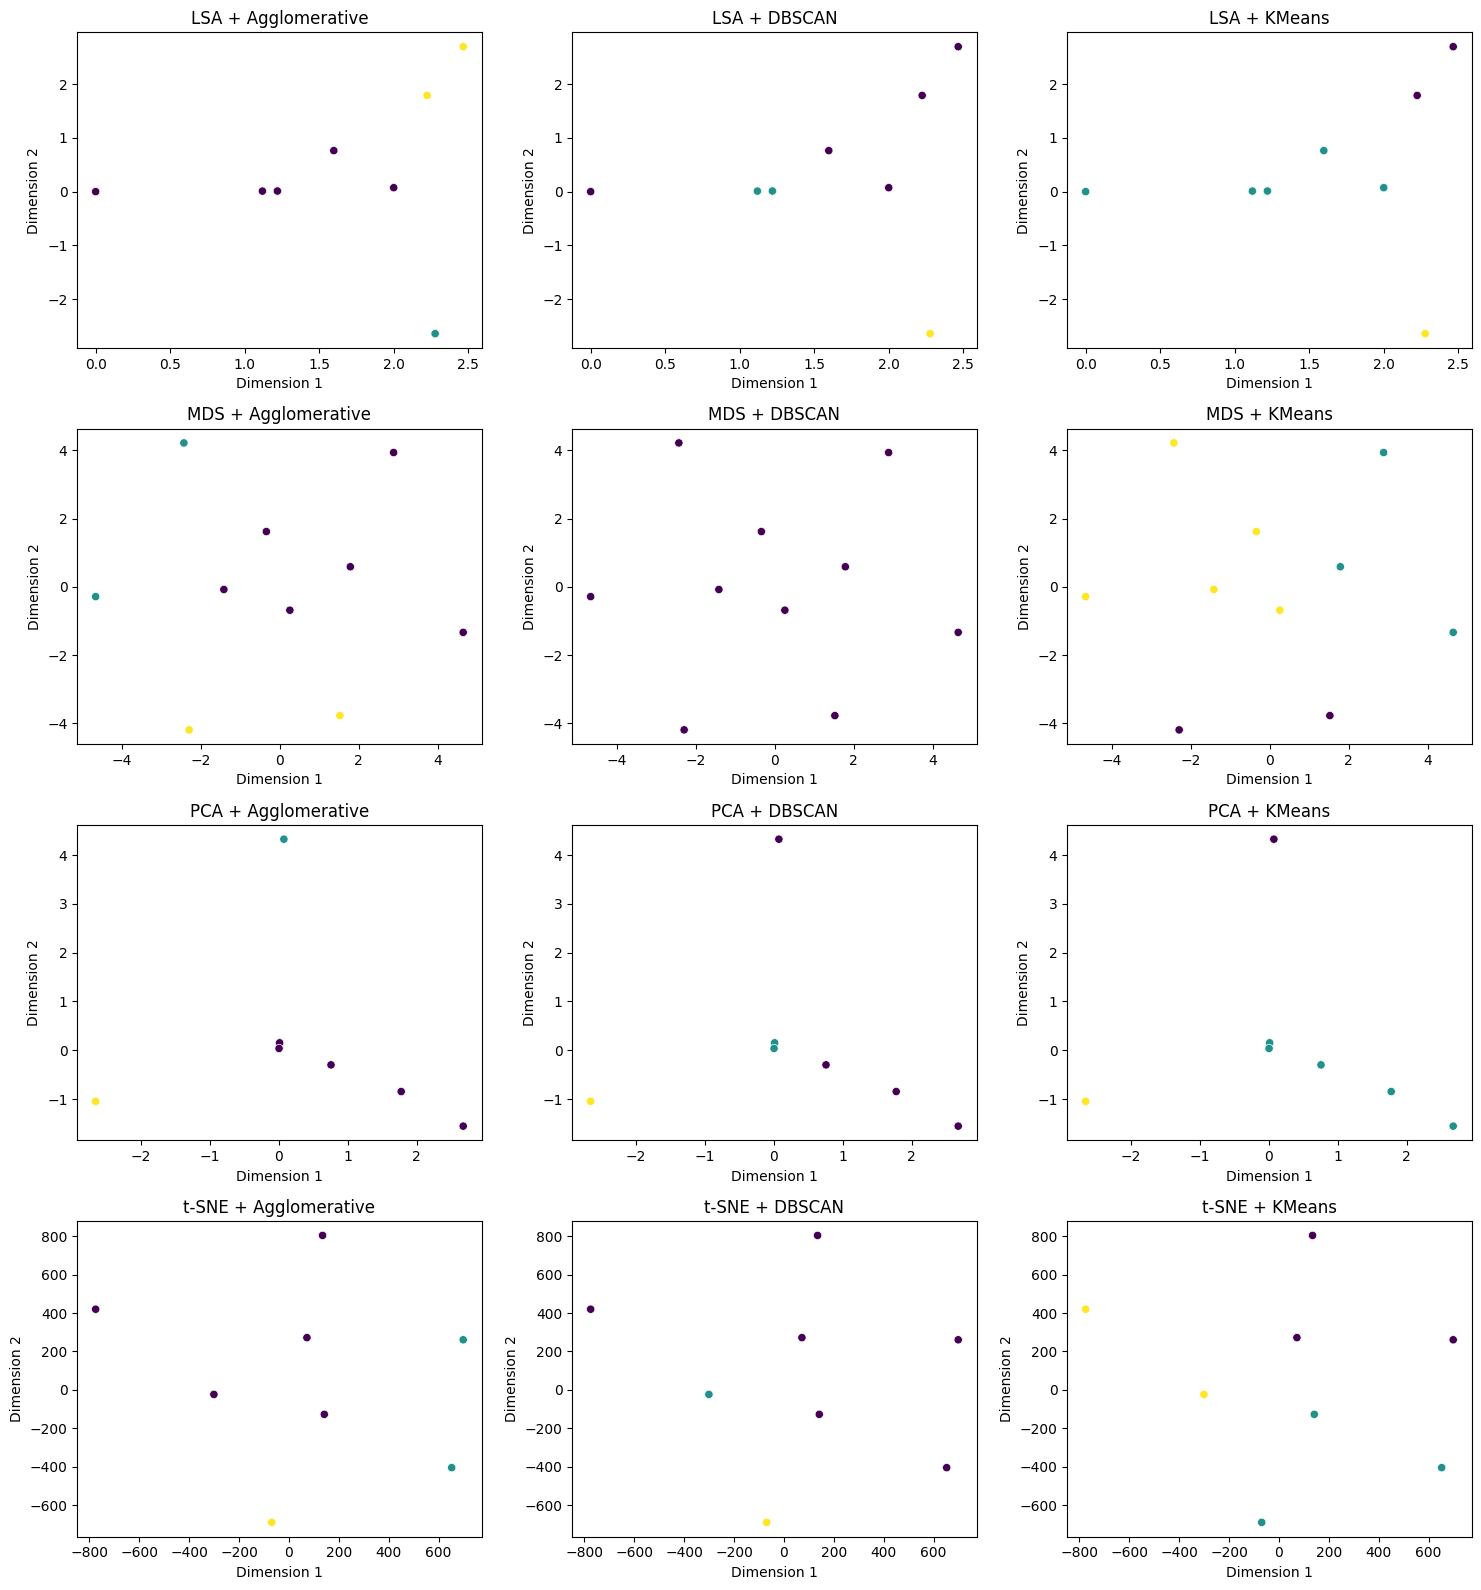

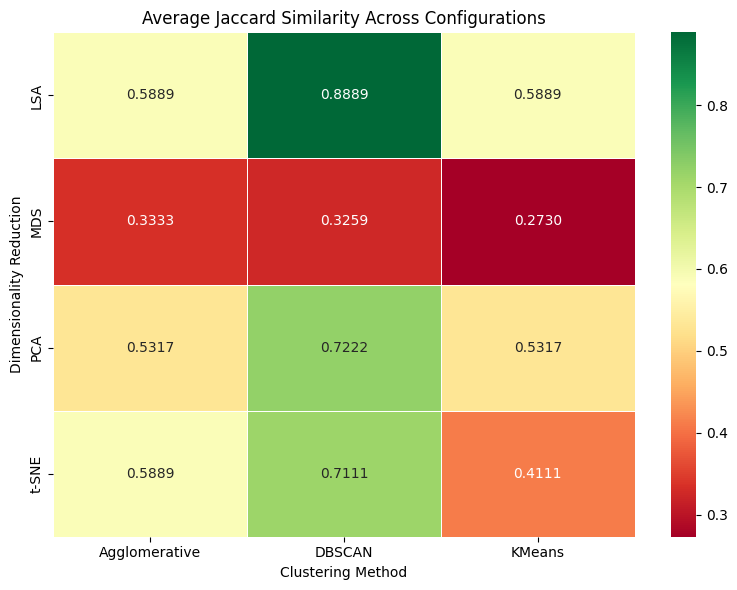


Average Jaccard Similarity Scores:
   Dimensionality Reduction Clustering Method  Average Jaccard Similarity
0                       LSA            KMeans                    0.588889
1                       LSA     Agglomerative                    0.588889
2                       LSA            DBSCAN                    0.888889
3                       PCA            KMeans                    0.531746
4                       PCA     Agglomerative                    0.531746
5                       PCA            DBSCAN                    0.722222
6                     t-SNE            KMeans                    0.411111
7                     t-SNE     Agglomerative                    0.588889
8                     t-SNE            DBSCAN                    0.711111
9                       MDS            KMeans                    0.273016
10                      MDS     Agglomerative                    0.333333
11                      MDS            DBSCAN                    0.325926


In [9]:
import numpy as np

from typing import List, Tuple, Dict, Set
import re
import warnings

from melon_clustering import PatternExtractorOneHot, ClusterEvaluator, ClusterManager

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)


# Sample Reference Clusters
reference_clusters = [
    [
        ('Krass, das habe ich noch nie gesehen!', 'Krass'),
        ('Krass, wie schnell du das geschafft hast.', 'Krass'),
        ('Krass, das war wirklich beeindruckend.', 'Krass')
    ],
    [
        ('Das war eine krass schwierige Entscheidung.', 'krass'),
        ('Er hatte eine krass interessante Idee.', 'krass'),
        ('Die krasse Veränderung hat alle überrascht.', 'krass')
    ],
    [
        ('Die Party war krass gut organisiert.', 'krass'),
        ('Er hat das krass schnell erledigt.', 'krass'),
        ('Sie war krass begeistert von dem Ergebnis.', 'krass'),
        ('Der Vortrag war krass langweilig.', 'krass')
    ]
]

# Initialize ClusterEvaluator
evaluator = ClusterEvaluator(reference_clusters=reference_clusters)

# Prepare sentences and sentence_id_to_original via ClusterEvaluator's static method
sentences_dict = evaluator.add_reference_sentences(reference_clusters)

# Initialize PatternExtractor
extractor = PatternExtractorOneHot(language='de', filter_threshold=1)

# Extract patterns with min_occurrences=1
extractor.extract_patterns_flat(sentences_dict, min_occurrences=1)

# Check if patterns were extracted
if len(extractor.pattern_list) == 0:
    print("No patterns were extracted. Please adjust filter_threshold or min_occurrences.")
else:
    # Map sentences to patterns
    sentence_pattern_mapping = extractor.map_sentences_to_patterns(sentences_dict)

    # Encode patterns using One-Hot Encoding
    one_hot_vectors = extractor.one_hot_encode_patterns(sentence_pattern_mapping)
    vectors = one_hot_vectors  # No cleaning needed for One-Hot vectors

    # Define dimensionality reduction methods and clustering methods
    dim_reduction_methods = ['LSA', 'PCA', 't-SNE', 'MDS']
    clustering_methods = ['KMeans', 'Agglomerative', 'DBSCAN']

    # Initialize ClusterManager
    cluster_manager = ClusterManager()

    # Run all configurations with annotations for individual plots
    results_df = cluster_manager.run_all_configurations(
        evaluator=evaluator,
        vectors=vectors,
        dim_methods=dim_reduction_methods,
        cluster_methods=clustering_methods,
        sentence_paths=extractor.sentence_paths,  # Pass sentence_paths correctly
        plot_seaborn = True,
        plot_plt = False,
        annotate_plt=True  # Set to True to annotate individual plots
    )

    # Display the results dataframe
    print("\nAverage Jaccard Similarity Scores:")
    print(results_df)
